In [1]:
# importing required libraries 
import time
import numpy as np
import pandas as pd

# for pytorch imports
import torch

# for functional dependencies like activation function 
import torch.nn.functional as F

# nn is basic module in Torch which provide different neural network architecture
import torch.nn as nn

# for optimizer
import torch.optim as optim

# for padding .. since the LSTM takes input as sequence so it is said that 
#if we have fixed input string computation will be faster and it will improve performance 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader

In [2]:
EPOCHS = 10
BATCH_SIZE = 25
MAX_WORDS_LEN = 200
LR = 1e-6

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# 学習データの準備
from torchtext.datasets import IMDB

train_iter, test_iter = IMDB()
df = pd.DataFrame([item for item in train_iter], columns=['label', 'text'])
df

,label,text
0,1,I rented I AM CURIOUS-YELLOW from my video sto...
1,1,"""I Am Curious: Yellow"" is a risible and preten..."
2,1,If only to avoid making this type of film in t...
3,1,This film was probably inspired by Godard's Ma...
4,1,"Oh, brother...after hearing about this ridicul..."
...,...,...
24995,2,A hit at the time but now better categorised a...
24996,2,I love this movie like no other. Another time ...
24997,2,This film and it's sequel Barry Mckenzie holds...
24998,2,'The Adventures Of Barry McKenzie' started lif...


<Axes: xlabel='label'>

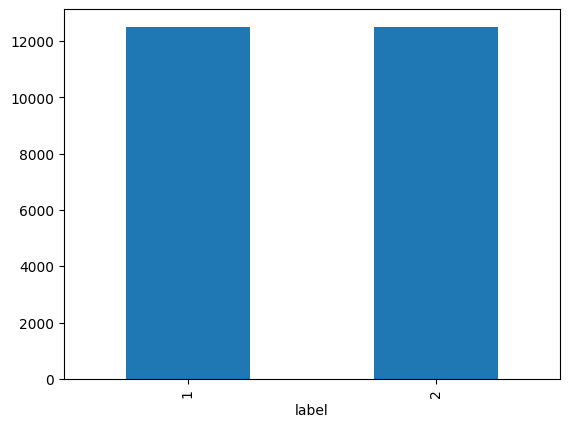

In [5]:
df.groupby(['label']).size().plot.bar()

In [21]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        return linear_output.squeeze()

model = BertClassifier().to(device)
model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [7]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def collate_batch(batch):
    labels = torch.Tensor([ele[0] - 1 for ele in batch])
    texts = tokenizer([ele[1] for ele in batch], padding='max_length', max_length = MAX_WORDS_LEN, truncation=True, return_tensors="pt") 
    return texts, labels

train_dataloader = DataLoader([a for a in train_iter], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader([a for a in test_iter], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

train_len = len(list(train_iter))
test_len = len(list(test_iter))

In [8]:
from torch.optim import Adam

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = Adam(model.parameters(), lr= LR)
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc.to('cpu').numpy()

for epoch_num in range(EPOCHS):

    total_acc_train = []
    total_loss_train = []
    total_acc_val = []
    total_loss_val = []

    time_s = time.perf_counter()
    model.train()
    for i, (train_input, train_label) in enumerate(train_dataloader):

        train_label = train_label.to(device)
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)

        optimizer.zero_grad()
        output = model(input_id, mask)
        
        batch_loss = criterion(output, train_label)
        total_loss_train.append(batch_loss.item())
        
        acc = binary_accuracy(output, train_label)
        total_acc_train.append(acc)

        batch_loss.backward()
        optimizer.step()

        print(f"epoch:{epoch_num+1}({(i + 1) / (train_len / BATCH_SIZE):.2%}) | Train Loss: {np.mean(total_loss_train):.3f}  Train Accuracy: {np.mean(total_acc_train):.3f} | Elapsed: {(time.perf_counter() - time_s):.1f}s", end='\r')

    print()
    time_s = time.perf_counter()
    model.eval()
    with torch.no_grad():

        for i, (val_input, val_label) in enumerate(val_dataloader):

            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, val_label)
            total_loss_val.append(batch_loss.item())
            
            acc = binary_accuracy(output, val_label)
            total_acc_val.append(acc)

            print(f"epoch:{epoch_num+1}({(i + 1) / (test_len / BATCH_SIZE):.2%}) | Train Loss: {np.mean(total_loss_val):.3f}  Train Accuracy: {np.mean(total_acc_val):.3f} | Elapsed: {(time.perf_counter() - time_s):.1f}s", end='\r')
    print()

epoch:1(100.00%) | Train Loss: 0.541  Train Accuracy: 0.720 | Elapsed: 621.8s
epoch:1(100.00%) | Train Loss: 0.339  Train Accuracy: 0.869 | Elapsed: 285.7s
epoch:2(100.00%) | Train Loss: 0.323  Train Accuracy: 0.873 | Elapsed: 619.3s
epoch:2(100.00%) | Train Loss: 0.287  Train Accuracy: 0.884 | Elapsed: 278.7s
epoch:3(100.00%) | Train Loss: 0.276  Train Accuracy: 0.891 | Elapsed: 616.1s
epoch:3(100.00%) | Train Loss: 0.259  Train Accuracy: 0.895 | Elapsed: 273.0s
epoch:4(100.00%) | Train Loss: 0.252  Train Accuracy: 0.901 | Elapsed: 612.3s
epoch:4(100.00%) | Train Loss: 0.252  Train Accuracy: 0.898 | Elapsed: 272.9s
epoch:5(100.00%) | Train Loss: 0.233  Train Accuracy: 0.909 | Elapsed: 612.8s
epoch:5(100.00%) | Train Loss: 0.248  Train Accuracy: 0.900 | Elapsed: 273.1s
epoch:6(100.00%) | Train Loss: 0.215  Train Accuracy: 0.919 | Elapsed: 650.4s
epoch:6(100.00%) | Train Loss: 0.243  Train Accuracy: 0.901 | Elapsed: 295.5s
epoch:7(100.00%) | Train Loss: 0.201  Train Accuracy: 0.923 | El

In [10]:
torch.save(model, '../models/BertClassifier_IMDB.pth')

In [16]:
with torch.no_grad():
    model.eval()
    val_input, val_label = next(iter(val_dataloader))
    val_label = val_label.to(device)
    mask = val_input['attention_mask'].to(device)
    input_id = val_input['input_ids'].squeeze(1).to(device)
    output = model(input_id, mask)

results = [(tokenizer.decode(input_id[i]), val_label[i].item(), torch.sigmoid(pred).item()) for i, pred in enumerate(output)]
pd.set_option('display.max_colwidth', 500)
df = pd.DataFrame(results, columns=['text', 'label', 'pred'])
df

,text,label,pred
0,[CLS] somewhere in the dark recesses of my brain cells a song plays in my head. i can't forget it no matter how hard i try. it's midnight madness and it's gonna get to you! wish i could find a copy of this on a 45rpm record. five disparate teams head out one night in l. a. for a scavenger hunt for clues instead of physical objects. an unkempt game - master with two gorgeous assistants is the mastermind of all this insanity that's about to be unleashed on l. a. all the teams are stereotypes (...,1.0,0.375375
1,"[CLS] this movie was dreadful. biblically very inaccurate. moses was 80 years old when he led the people out of egypt, the movie has him about forty. moses was about forty when he fled egypt, was gone for forty years, and was with them wandering for forty years. moses was 120 years old when he died, and was denied the privilege of crossing over to the promised land. i realize movies use a lot of "" poetic license "" as the biblical account isn't that long, but, if making a biblical movie they ...",0.0,0.006526
2,"[CLS] great cast, great acting, great music. each character in this movie had their own stories and personalities and it's vivid. a great movie not to be missed. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD...",1.0,0.995010
3,"[CLS] i try to catch this film each time it's shown on tv, which happily is quite often. but i keep forgetting to video it. as it is, i practically know the script by heart, but that doesn't stop me having a good cry, in fact it probably adds to it as i cry knowing what's coming next. it's such a lovely film - well made, well cast, good photography. i love it. one of my top ten films. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ...",1.0,0.994089
4,"[CLS] "" are you in the house alone? "" belongs to the pre - cable tv days when the networks were eager to offer an alternative to popular tv shows. it is well - made thriller with a talented cast and credible situations. kathleen beller plays a high school student who gets a series of threatening letters. everyone seems to think that it is nothing more than a prank but beller is really scared. tony bill and blythe danner play beller's parents, ellen travolta ( john's sister ) is the high scho...",1.0,0.995534
5,[CLS] i found this movie to be a simple yet wonderful comedy. this movie is purely entertaining. i can watch it time and time again and still enjoy the dialog and chemistry between the characters. i truly hope for a dvd release! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA...,1.0,0.994081
6,[CLS] this tearful movie about a sister and her battle to save as many souls as she can is very moving. the film does well in picking up the characters and showing how sister helen deals with each. < br / > < br / > a wonderful journey from life to death. < br / > < br / > [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] ...,1.0,0.995389
7,"[CLS] i have not managed to completely block out this film from memory even though it has been two years since i've seen it. < br / > < br / > don't get me wrong - i have long forgotten the main story line - the relationship between kidman and law, that made no impression on me but it was the torture scenes in the film that really struck me. i cried for about t